In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import variable_transformers as vt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
#Combine the details dataframe with saleshistory dataframe
details = pd.read_csv('Data/house_data_details_cleaned.csv')
history = pd.read_csv('Data/house_data_saleshistory_cleaned.csv')

In [3]:
print(details.shape, history.shape)
raw_data = pd.merge(details, history, on='parcel_number', how='left')
print(raw_data.shape)

#There are some properties in the saleshistory dataframe that are not 
#in the details dataframe. That is why the total number of observations
#do not add up after the merge

#raw_data.head()

(11123, 26) (12825, 3)
(19351, 28)


In [4]:
#We'll be keeping the values from the right dataframe(for columns date and sale_price) since they exist in both dataframes
#There are a lot of null values for properties that are not in the saleshistory.We'll fill those missing values 
#with the values from the left dataframe and then drop the duplicate features from the left dataframe

print(f'Number of missing values for price after the merge and before the imputation: {raw_data.price.isnull().sum()}')
missing = raw_data.loc[raw_data['price'].isnull()].index
raw_data['date_y'] = raw_data['date_y'].fillna(raw_data['date_x'])
raw_data['price'] = raw_data['price'].fillna(raw_data['sale_price'])

raw_data.drop(['date_x', 'sale_price'], axis=1, inplace=True)
raw_data.rename(columns={'date_y': 'date', 'price':'sale_price'}, inplace=True)

print(f'Number of missing values for price after imputing the missing values: {raw_data.sale_price.isnull().sum()}')
raw_data.head()

Number of missing values for price after the merge and before the imputation: 6758
Number of missing values for price after imputing the missing values: 338


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,date,sale_price
0,33.97462,-118.13368,6224 Nye St,Condominium,1357.00000,2221560.00000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000,2020-09-28,469000.00000
1,34.15656,-118.39689,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan,2020-09-28,1910000.00000
2,34.67778,-118.45117,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000,2020-09-28,325000.00000
3,34.07296,-118.06690,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000,2020-09-28,738000.00000
4,33.77772,-118.15491,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000,2020-09-28,1185000.00000


In [5]:
df = raw_data.copy()
df.describe()

,latitude,longitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,sale_price
count,19351.00000,19351.00000,18539.00000,19260.00000,18697.00000,19351.00000,19342.00000,19351.00000,19351.00000,18078.00000,19351.00000,19351.00000,19351.00000,18003.00000,18003.00000,19013.00000
mean,34.12465,-118.27511,35485.17709,3710646.72336,1964.84848,4952899494.62446,1111875204.11436,2.01121,458212.98822,872081.88959,7.43465,6.92708,1.20082,3.37466,2.71371,3679706.42913
std,0.23356,0.21641,595394.11466,23589413.59415,25.87139,2102033978.11976,527569.41064,1.10457,268168.86202,551995.75033,13.28439,6.67310,0.43274,3.63692,4.75768,15067957.34117
min,33.70724,-118.89009,3.00000,120.00000,1883.00000,6637311.00000,1110722482.00000,1.00000,0.00000,104000.00000,0.00000,1.00000,0.00000,1.00000,1.00000,500.00000
25%,33.97433,-118.43467,1200.00000,6017.75000,1949.00000,3001038075.00000,1111397056.25000,1.00000,214600.00000,502900.00000,1.00000,3.00000,1.00000,2.00000,2.00000,534000.00000
50%,34.09725,-118.29152,1583.00000,7798.00000,1963.00000,5035015030.00000,1112087238.00000,2.00000,432401.00000,697400.00000,3.00000,5.00000,1.00000,3.00000,2.00000,1165000.00000
75%,34.20443,-118.13440,2262.00000,20242.50000,1985.00000,7063014025.00000,1112303372.00000,3.00000,620522.00000,1037000.00000,8.00000,8.00000,1.00000,4.00000,3.00000,4100000.00000
max,34.81875,-117.61020,29533680.00000,1248647400.00000,2020.00000,8765024023.00000,1112630129.00000,8.00000,980019.00000,2999000.00000,135.00000,125.00000,4.00000,136.00000,175.00000,1660000000.00000


In [6]:
#Alternatively
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

In [7]:
#Before removing the observations with missing values, 
#let's remove the features we won't need so we can limit the number of observations we will need
dropped_features = ['address', 'realtyID', 'county', 'subdivision', 'census', 'tract', 'lot', 'estimated_value', 'url']

#Remove missing values for the target feature
print(f'Number of observations before removing missing values: {df.shape[0]}')
df.drop(dropped_features, axis=1, inplace=True)
df.dropna(inplace=True)
print(f'Number of observations after removing missing values without removing bad features: {raw_data.dropna().shape[0]}')
print(f'Number of observations after removing missing values after removing bad features: {df.shape[0]}')

Number of observations before removing missing values: 19351
Number of observations after removing missing values without removing bad features: 13405
Number of observations after removing missing values after removing bad features: 15107


In [8]:
#Convert date into a datetime object
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0       2069-09-19
1       2069-07-01
2       2069-04-23
3       2069-01-22
4       2068-06-05
           ...    
15102   1967-10-13
15103   1967-01-03
15104   1965-05-10
15105   1964-07-29
15106   1964-06-10
Name: date, Length: 15107, dtype: datetime64[ns]

In [9]:
#Correct the dates
df['date'] = df['date'].apply(lambda x: x.replace(year= x.year-100) if x.year>2020 else x)
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0       2020-11-04
1       2020-11-03
2       2020-11-03
3       2020-11-03
4       2020-11-03
           ...    
15102   1965-01-11
15103   1964-12-18
15104   1964-07-29
15105   1964-07-02
15106   1964-06-10
Name: date, Length: 15107, dtype: datetime64[ns]

In [10]:
#We need to adjust the prices based on inflation
#Add a new column that will be used for the merge
df['observation_date'] = df['date'].values.astype('datetime64[M]')

#Read in a file with consumer price index
cpi_df = pd.read_csv('CPIAUCNS.csv')
cpi_df['observation_date'] = pd.to_datetime(cpi_df['observation_date'])

cpi_df.sort_values(by='observation_date', ascending=False, inplace=True, ignore_index=True)

merged_df = pd.merge(df, cpi_df, on='observation_date', how='left')
merged_df.drop_duplicates(inplace=True)
merged_df.rename(columns={'CPIAUCNS':'cpi'}, inplace=True)
merged_df[:5]

,latitude,longitude,property_type,home_size,lot_size,year_built,parcel_number,zoning,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,bedrooms,bathrooms,date,sale_price,observation_date,cpi
0,33.95678,-118.38298,"Triplex (3 units, any combination)",3156.00000,7011.00000,1950.00000,4125012006,LAR3,3,Slightly High,15,1,Average,6.00000,3.00000,2020-11-04,11325000.00000,2020-11-01,260.40000
1,34.10604,-118.04516,Single Family Residence,1784.00000,13119.00000,1948.00000,8586005008,ARR1,2,Low,3,1,Excellent,4.00000,3.00000,2020-11-03,12380000.00000,2020-11-01,260.40000
2,34.11466,-117.90995,Condominium,1060.00000,2787840.00000,1989.00000,8614016044,AZR3B,7,Moderate,6,1,Average,3.00000,2.00000,2020-11-03,3930000.00000,2020-11-01,260.40000
3,34.13660,-118.20185,Single Family Residence,684.00000,6634.00000,1922.00000,5689014009,LAR1,5,Slightly High,4,1,Excellent,2.00000,1.00000,2020-11-03,8650000.00000,2020-11-01,260.40000
4,33.96655,-118.22627,"Quadplex (4 Units, Any Combination)",2939.00000,4795.00000,1924.00000,6202011008,LCR305,19,Slightly High,8,1,Poor,8.00000,4.00000,2020-11-03,7450000.00000,2020-11-01,260.40000


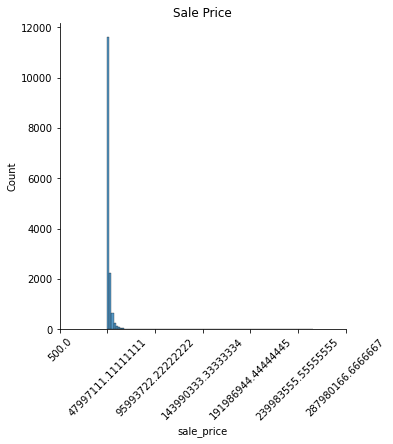

In [11]:
#Plot the sale_price distribution
chart = sns.displot(merged_df['sale_price'], bins=100)
plt.title('Sale Price')
plt.ticklabel_format(style='plain', axis='x')
min_price = merged_df['sale_price'].min()
max_price = merged_df['sale_price'].max()
steps = (max_price-min_price)/9.0
labels = np.arange(min_price, max_price+1, steps)
chart.set(xticklabels=labels)
chart.set_xticklabels(rotation=45);

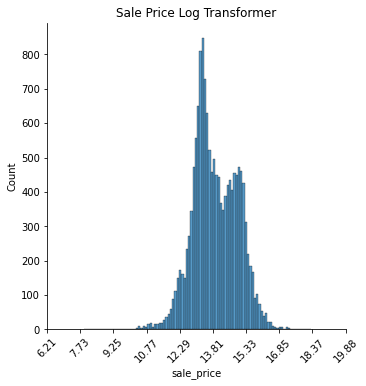

In [13]:
#Use a Log Transformer
lt = vt.LogTransformer(variables = ['sale_price', 'cpi'])
lt.fit(merged_df)

transformed_df = lt.transform(merged_df)

chart = sns.displot(transformed_df['sale_price'], bins=100)
plt.title('Sale Price Log Transformer')
plt.ticklabel_format(style='plain', axis='x')
min_price = transformed_df['sale_price'].min()
max_price = transformed_df['sale_price'].max()
steps = (max_price-min_price)/9.0
labels = np.round(np.arange(min_price, max_price+1, steps),2)
chart.set(xticklabels=labels)
chart.set_xticklabels(rotation=45);

### Remove outliers instead of using log transformer

The sale price upper boundary is 7460000.0
Number of observations before removing outliers: 15107
Number of observations after removing outliers: 13405


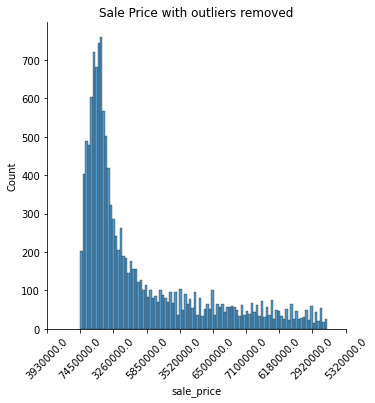

In [12]:
#This function will identify the outlier boundaries for a variable

def find_skewed_boundaries(df, var, distance):
    
    IQR = df['sale_price'].quantile(.75) - df['sale_price'].quantile(.25)
    
    lower_boundary = df['sale_price'].quantile(.25) - (distance*IQR)
    upper_boundary = df['sale_price'].quantile(.75) + (distance*IQR)
    
    return upper_boundary, lower_boundary


sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(merged_df, 'sale_price', 1.0)
print(f'The sale price upper boundary is {sales_upper_boundary}')

#Remove outlier values
df_trimmed = merged_df.loc[merged_df['sale_price']<sales_upper_boundary,:]
print(f'Number of observations before removing outliers: {merged_df.shape[0]}')
print(f'Number of observations after removing outliers: {df_trimmed.shape[0]}')

chart = sns.displot(df_trimmed['sale_price'], bins=100)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=df_trimmed['sale_price'])
chart.set_xticklabels(rotation=45);

### Variable Transformers

In [41]:
#Log Transformer
lt = vt.LogTransformer(variables = ['sale_price'])
lt.fit(df_trimmed)

temp = lt.transform(df_trimmed)

#Recirprocal Transformer
rt = vt.ReciprocalTransformer(variables = ['sale_price'])
rt.fit(df_trimmed)

temp = rt.transform(df_trimmed)

#Power Transformer
et = vt.PowerTransformer(variables = ['sale_price'])
et.fit(df_trimmed)

temp = et.transform(df_trimmed)

#Box Cox Transformer
bct = vt.BoxCoxTransformer(variables = ['sale_price'])
bct.fit(df_trimmed)

temp = bct.transform(df_trimmed)

#Yeo Johnson Transformer
yjt = vt.YeoJohnsonTransformer(variables = ['sale_price'])
yjt.fit(df_trimmed)

temp = bct.transform(df_trimmed)

In [15]:
#Determine the age of the property 
transformed_df['age'] = transformed_df['date'].dt.year - transformed_df['year_built']
transformed_df[['year_built','age']][:5]

,year_built,age
0,1950.00000,70.00000
1,1948.00000,72.00000
2,1989.00000,31.00000
3,1922.00000,98.00000
4,1924.00000,96.00000


In [16]:
#Examine the property type feature
temp = pd.concat([transformed_df.groupby('property_type')['sale_price'].mean(), transformed_df.groupby('property_type')['sale_price'].count(), df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price', 'Count of property_type', 'Percentage of property type']
temp.sort_values(by=['Count of property_type'], axis=0,ascending=False, inplace=True)
print(f'Number of categories for property_type: {transformed_df.property_type.nunique()}')
temp

Number of categories for property_type: 25


,Average sale price,Count of property_type,Percentage of property type
Single Family Residence,14.17002,9649,0.63871
Condominium,13.94535,3654,0.24187
"Duplex (2 units, any combination)",14.01020,579,0.03833
Planned Unit Development (PUD),14.17419,508,0.03363
Apartment house (5+ units),14.82791,231,0.01529
"Triplex (3 units, any combination)",14.22719,211,0.01397
"Quadplex (4 Units, Any Combination)",14.45832,194,0.01284
MISCELLANEOUS (Commercial),13.68681,17,0.00113
"Parking Garage, Parking Structure",14.26814,10,0.00066
Residential - Vacant Land,13.98264,8,0.00053


In [17]:
#Only keep the Single Family Residence 
transformed_df = transformed_df.loc[transformed_df['property_type']=='Single Family Residence']
print(f'Number of observations after removing every proprety type except Single Family Residence\'s: {transformed_df.shape[0]}')

Number of observations after removing every proprety type except Single Family Residence's: 9649


In [18]:
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['crime_index', 'school_quality'])

ohe_encoder.fit(transformed_df)

temp = ohe_encoder.transform(transformed_df)

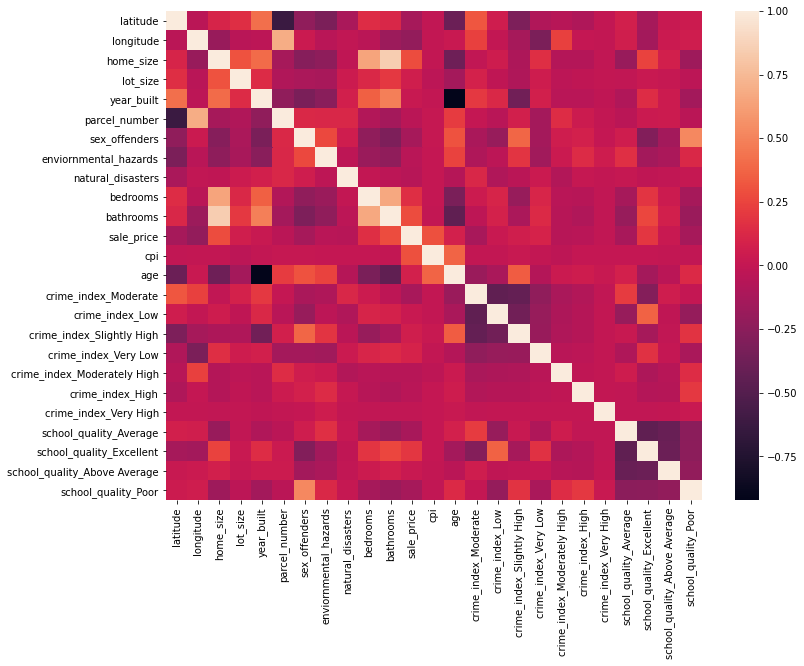

In [19]:
corrmat = temp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

In [84]:
def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(temp, 0.6)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  4
{'parcel_number', 'bathrooms', 'age', 'bedrooms'}


In [105]:
def diagnostic_plots(df, variable, labels):
  
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)

In [20]:
#Let's examine crime index
temp = pd.concat([transformed_df.groupby('crime_index')['sale_price'].mean(), transformed_df.groupby('crime_index')['sale_price'].count()], axis=1)
temp.columns = ['Average sale price', 'Count of crime index type']
temp['Average sale price'] = np.exp(temp['Average sale price'])
temp.sort_values(by='Average sale price', ascending=False, inplace=True)
temp['Average sale price'] = temp['Average sale price'].apply(lambda x: '${:,.2f}'.format(x))
temp

,Average sale price,Count of crime index type
crime_index,,
Very Low,"$2,175,676.49",896
Slightly High,"$1,667,487.90",2465
Low,"$1,527,182.82",2662
Moderate,"$1,125,595.45",3275
Moderately High,"$909,073.73",240
High,"$783,091.08",110
Very High,"$337,000.00",1


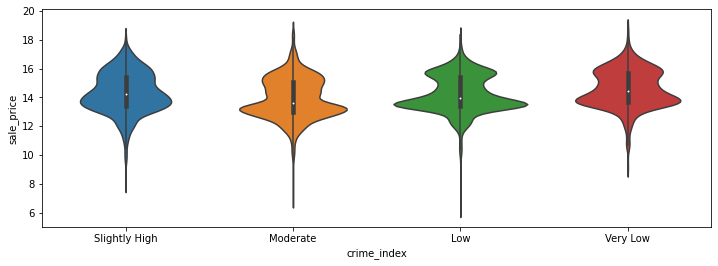

In [21]:
order=['Slightly High', 'Moderate', 'Low', 'Very Low']
temp = transformed_df.loc[((transformed_df['crime_index']!='High') & (transformed_df['crime_index']!='Moderately High'))]
plt.figure(figsize=(12,4))
sns.violinplot(x='crime_index', y='sale_price', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [22]:
#Let's examine school quality
temp = pd.concat([transformed_df.groupby('school_quality')['sale_price'].mean(), transformed_df.groupby('school_quality')['sale_price'].count()], axis=1)
temp.columns = ['Average sale price', 'Count of school_quality types']
temp['Average sale price'] = np.exp(temp['Average sale price'])
temp.sort_values(by='Average sale price', ascending=False, inplace=True)
temp['Average sale price'] = temp['Average sale price'].apply(lambda x: '${:,.2f}'.format(x))
temp

,Average sale price,Count of school_quality types
school_quality,,
Excellent,"$2,152,476.42",2848
Above Average,"$1,505,032.25",2566
Average,"$1,111,833.12",3071
Poor,"$888,779.27",1164


In [23]:
#Lets remove the features that won't be needed for the model
drop_features = ['year_built', 'parcel_number', 'date', 'observation_date', 'property_type']

final_df = transformed_df.drop(drop_features, axis=1)

In [24]:
final_df.to_csv('Data/house_data_details_eda.csv', index=False)